In [1]:
import pandas as pd
df = pd.read_csv('./865214564_T_T100_MARKET_ALL_CARRIER.csv').rename(lambda x: x.lower(), axis = 1)
df.head()

,passengers,freight,mail,distance,unique_carrier,airline_id,unique_carrier_name,unique_carrier_entity,region,carrier,...,dest_state_nm,dest_country,dest_country_name,dest_wac,year,quarter,month,distance_group,class,data_source
0,0,53185,0,8165,EK,20392,Emirates,9678A,I,EK,...,Texas,US,United States,74,2019,1,3,17,G,IF
1,0,9002,0,6849,EK,20392,Emirates,9678A,I,EK,...,New York,US,United States,22,2019,1,3,14,G,IF
2,0,2220750,0,7247,EK,20392,Emirates,9678A,I,EK,...,Illinois,US,United States,41,2019,1,3,15,G,IF
3,0,1201490,0,8165,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,17,G,IF
4,0,248642,0,6849,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,14,G,IF


In [2]:
df.columns

Index(['passengers', 'freight', 'mail', 'distance', 'unique_carrier',
       'airline_id', 'unique_carrier_name', 'unique_carrier_entity', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id',
       'origin', 'origin_city_name', 'origin_state_abr', 'origin_state_fips',
       'origin_state_nm', 'origin_country', 'origin_country_name',
       'origin_wac', 'dest_airport_id', 'dest_airport_seq_id',
       'dest_city_market_id', 'dest', 'dest_city_name', 'dest_state_abr',
       'dest_state_fips', 'dest_state_nm', 'dest_country', 'dest_country_name',
       'dest_wac', 'year', 'quarter', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [3]:
df.unique_carrier_name.nunique()

318

In [4]:
df.query('origin_country_name == "United Kingdom" and dest_country_name == "United States"')[['freight', 'mail', 'passengers']].sum()

freight       903296879
mail           29838395
passengers     10685608
dtype: int64

In [5]:
df[['unique_carrier_name', 'origin', 'dest', 'distance']].drop_duplicates()\
    .groupby('unique_carrier_name').distance.median().nlargest(5)

unique_carrier_name
Singapore Airlines Ltd.                                       8068.0
Cathay Pacific Airways Ltd.                                   8020.0
Qantas Airways Ltd.                                           7886.0
Longtail Aviation Ltd.                                        7855.5
National Aviation Company of India Limited d/b/a Air India    7798.0
Name: distance, dtype: float64

In [6]:
df.assign(cargo=lambda x: x.mail  + x.freight).groupby('unique_carrier_name')[['cargo', 'distance']].agg(dict(cargo='sum', distance='mean')).nlargest(10, 'cargo')

,cargo,distance
unique_carrier_name,,
Federal Express Corporation,12709663842,1121.887981
United Parcel Service,9173866790,1030.812650
Atlas Air Inc.,3356847309,1900.987202
United Air Lines Inc.,1577891983,1810.656058
American Airlines Inc.,1353074248,1583.185048
Kalitta Air LLC,1272180283,2519.580343
Polar Air Cargo Airways,1199386139,3111.794118
Delta Air Lines Inc.,1129523987,1612.688752
China Airlines Ltd.,837079895,5828.277778


In [7]:
top10 = df.query('origin_country_name == "United States" and dest_country_name != "United States"').groupby('unique_carrier_name').passengers.sum().nlargest(10)
top10

unique_carrier_name
American Airlines Inc.       14867653
United Air Lines Inc.        14427923
Delta Air Lines Inc.         13054230
JetBlue Airways               4522492
British Airways Plc           3758945
Lufthansa German Airlines     3123611
Westjet                       2626600
Air Canada                    2540855
Southwest Airlines Co.        2146960
Virgin Atlantic Airways       2074735
Name: passengers, dtype: int64

In [8]:
df.query('origin_country_name == "United States" and dest_country_name != "United States"')\
    .groupby(['unique_carrier_name', 'dest_country_name']).passengers.sum()\
    .groupby(level=0, group_keys=False).nlargest(1)[top10.index]

unique_carrier_name        dest_country_name 
American Airlines Inc.     Mexico                2424606
United Air Lines Inc.      Mexico                2201389
Delta Air Lines Inc.       Mexico                1872840
JetBlue Airways            Dominican Republic    1413023
British Airways Plc        United Kingdom        3758945
Lufthansa German Airlines  Germany               3123209
Westjet                    Canada                2626600
Air Canada                 Canada                2540855
Southwest Airlines Co.     Mexico                1001375
Virgin Atlantic Airways    United Kingdom        2074735
Name: passengers, dtype: int64

In [9]:
df.query(
    'origin_country_name.isin(["Canada", "Dominican Republic", "Germany", "Mexico", "United Kingdom", "United States"])'
    ' and dest_country_name.isin(["Canada", "Dominican Republic", "Germany", "Mexico", "United Kingdom", "United States"])'
    f' and dest_country_name != origin_country_name and unique_carrier_name.isin({top10.index.to_list()})'
).groupby('unique_carrier_name').passengers.sum().sort_values(ascending=False)


unique_carrier_name
United Air Lines Inc.        12237405
American Airlines Inc.       11091254
Delta Air Lines Inc.          8914478
British Airways Plc           7531344
Lufthansa German Airlines     6298202
Westjet                       5273827
Air Canada                    5044089
Virgin Atlantic Airways       4140090
JetBlue Airways               3770798
Southwest Airlines Co.        2284341
Name: passengers, dtype: int64

In [10]:
top_route = df.sort_values(['origin_city_name', 'dest_city_name']).assign(
    route=lambda x: 
        x[['origin_city_name', 'dest_city_name']].min(axis=1) \
        + '-' \
        + x[['origin_city_name', 'dest_city_name']].max(axis=1)
).groupby('route').passengers.sum().nlargest(1)
top_route

route
Chicago, IL-New York, NY    4131579
Name: passengers, dtype: int64

In [11]:
top_3 = df.sort_values(['origin_city_name', 'dest_city_name']).assign(
    route=lambda x: 
        x[['origin_city_name', 'dest_city_name']].min(axis=1) \
        + '-' \
        + x[['origin_city_name', 'dest_city_name']].max(axis=1)
).query(
    'route == "Chicago, IL-New York, NY"'
).groupby('unique_carrier_name').passengers.sum().div(top_route.iloc[0]).nlargest(3)
top_3

unique_carrier_name
American Airlines Inc.    0.313051
United Air Lines Inc.     0.232274
Delta Air Lines Inc.      0.133334
Name: passengers, dtype: float64

In [12]:
import numpy as np

international_passenger_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
).groupby('international_country').passengers.sum()

international_travel_pct = (international_passenger_travel / international_passenger_travel.sum()*100).nlargest(5)
international_travel_pct

international_country
Canada            13.159041
Mexico            12.729475
United Kingdom     8.874333
Germany            4.509554
Japan              4.146093
Name: passengers, dtype: float64

In [13]:
df.query(
    f'origin_country_name != dest_country_name and unique_carrier_name.isin({top10.index.to_list()})'
)[['origin_country_name','dest_country_name','unique_carrier_name','origin_city_name','dest_city_name','passengers']]

,origin_country_name,dest_country_name,unique_carrier_name,origin_city_name,dest_city_name,passengers
2795,United States,Canada,United Air Lines Inc.,"Wichita, KS","Toronto, Canada",0
2846,United States,Canada,United Air Lines Inc.,"Norfolk, VA","Toronto, Canada",0
2852,United States,Canada,United Air Lines Inc.,"Portland, OR","Toronto, Canada",0
2865,United States,Canada,United Air Lines Inc.,"Pittsburgh, PA","Calgary, Canada",0
2870,United States,Canada,United Air Lines Inc.,"Richmond, VA","Toronto, Canada",0
...,...,...,...,...,...,...
321051,United States,United Kingdom,British Airways Plc,"New York, NY","London, United Kingdom",57313
321091,United Kingdom,United States,British Airways Plc,"London, United Kingdom","New York, NY",58359
321112,United States,United Kingdom,British Airways Plc,"New York, NY","London, United Kingdom",58959
321114,United Kingdom,United States,British Airways Plc,"London, United Kingdom","New York, NY",59123


In [14]:
df.query(
    f'origin_country_name != dest_country_name and unique_carrier_name.isin({top10.index.to_list()})'
).assign(
  us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
  international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)  
)[['origin_country_name','dest_country_name','unique_carrier_name','origin_city_name','dest_city_name','us_city','international_country', 'passengers']]

,origin_country_name,dest_country_name,unique_carrier_name,origin_city_name,dest_city_name,us_city,international_country,passengers
2795,United States,Canada,United Air Lines Inc.,"Wichita, KS","Toronto, Canada","Wichita, KS",Canada,0
2846,United States,Canada,United Air Lines Inc.,"Norfolk, VA","Toronto, Canada","Norfolk, VA",Canada,0
2852,United States,Canada,United Air Lines Inc.,"Portland, OR","Toronto, Canada","Portland, OR",Canada,0
2865,United States,Canada,United Air Lines Inc.,"Pittsburgh, PA","Calgary, Canada","Pittsburgh, PA",Canada,0
2870,United States,Canada,United Air Lines Inc.,"Richmond, VA","Toronto, Canada","Richmond, VA",Canada,0
...,...,...,...,...,...,...,...,...
321051,United States,United Kingdom,British Airways Plc,"New York, NY","London, United Kingdom","New York, NY",United Kingdom,57313
321091,United Kingdom,United States,British Airways Plc,"London, United Kingdom","New York, NY","New York, NY",United Kingdom,58359
321112,United States,United Kingdom,British Airways Plc,"New York, NY","London, United Kingdom","New York, NY",United Kingdom,58959
321114,United Kingdom,United States,British Airways Plc,"London, United Kingdom","New York, NY","New York, NY",United Kingdom,59123


In [15]:
df.query(
    f'origin_country_name != dest_country_name and unique_carrier_name.isin({top10.index.to_list()})'
).assign(
  us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
  international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)  
).pivot_table(
    index='us_city', columns='international_country', 
    values='passengers', aggfunc='sum', margins=True
)

international_country,Antigua and Barbuda,Argentina,Aruba,Australia,Barbados,Belgium,Belize,Bermuda,Bolivia,"Bonaire, Sint Eustatius, and Saba",...,Sweden,Switzerland,Taiwan,The Bahamas,Trinidad and Tobago,Turks and Caicos Islands,United Kingdom,Uruguay,Venezuela,All
us_city,,,,,,,,,,,,,,,,,,,,,
"Albany, NY",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
"Albuquerque, NM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,27
"Allentown/Bethlehem/Easton, PA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
"Anchorage, AK",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48026
"Atlanta, GA",11564.0,159740.0,147144.0,NaN,NaN,89935.0,107109.0,75547.0,NaN,29099.0,...,NaN,43320.0,NaN,400147.0,26.0,107410.0,773873.0,3.0,NaN,10544357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Washington, DC",NaN,0.0,17430.0,NaN,NaN,159879.0,8.0,20840.0,NaN,NaN,...,NaN,213000.0,NaN,7025.0,63.0,6060.0,859216.0,NaN,NaN,3672657
"West Palm Beach/Palm Beach, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,158.0,NaN,NaN,NaN,66809
"White Plains, NY",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494


In [16]:
df.query(
    f'origin_country_name != dest_country_name and unique_carrier_name.isin({top10.index.to_list()})'
).assign(
  us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
  international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)  
).pivot_table(
    index='us_city', columns='international_country', 
    values='passengers', aggfunc='sum', margins=True
).sort_values('All', ascending=False, axis=1).drop('All').sort_values('All', ascending=False).drop(columns='All').iloc[:10,:10]

international_country,United Kingdom,Mexico,Canada,Germany,Dominican Republic,Japan,Jamaica,Netherlands,France,China
us_city,,,,,,,,,,
"New York, NY",3599328.0,860173.0,1566104.0,853674.0,2443025.0,3832.0,740717.0,323223.0,471080.0,NaN
"Miami, FL",1037798.0,854086.0,412699.0,375279.0,916565.0,NaN,540691.0,NaN,169557.0,NaN
"Atlanta, GA",773873.0,1569084.0,741236.0,659374.0,462258.0,191342.0,502099.0,499415.0,354917.0,165246.0
"Newark, NJ",1240972.0,633896.0,332936.0,881199.0,868299.0,210033.0,145932.0,151797.0,218570.0,331812.0
"Los Angeles, CA",1385302.0,1327190.0,2286098.0,646628.0,NaN,691868.0,21.0,85930.0,131043.0,644707.0
"Houston, TX",494729.0,2136212.0,822001.0,546553.0,49424.0,165168.0,121717.0,155192.0,277.0,103.0
"San Francisco, CA",1052684.0,584699.0,1597143.0,963039.0,NaN,481210.0,NaN,88737.0,155541.0,513823.0
"Chicago, IL",1263991.0,1091008.0,984908.0,1080619.0,163593.0,206955.0,170676.0,119457.0,242553.0,324351.0
"Dallas/Fort Worth, TX",751539.0,2047306.0,446766.0,359896.0,17801.0,327051.0,88858.0,67102.0,211081.0,311610.0


In [17]:
international_travel = df.query(
  'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
)



In [18]:
international_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
)

pd.crosstab(
    index=international_travel.unique_carrier_name, columns=international_travel.international_country, 
    values=international_travel.passengers, aggfunc='sum', normalize='index'
).loc[top_3.index, international_travel_pct.index]

international_country,Canada,Mexico,United Kingdom,Germany,Japan
unique_carrier_name,,,,,
American Airlines Inc.,0.036028,0.162185,0.112027,0.016612,0.024537
United Air Lines Inc.,0.079888,0.152699,0.085046,0.077082,0.082790
Delta Air Lines Inc.,0.059044,0.143440,0.052836,0.035196,0.061896


In [24]:
international_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
)

international_travel[['class', 'origin_city_name', 'dest_city_name']]

,class,origin_city_name,dest_city_name
2251,F,"Road Town, British Virgin Islands","Charlotte Amalie, VI"
2262,F,"Charlotte Amalie, VI","Road Town, British Virgin Islands"
2263,F,"Charlotte Amalie, VI","Virgin Gorda, British Virgin Islands"
2264,F,"Virgin Gorda, British Virgin Islands","Charlotte Amalie, VI"
2313,F,"Burlington, VT","Quebec, Canada"
...,...,...,...
321051,F,"New York, NY","London, United Kingdom"
321091,F,"London, United Kingdom","New York, NY"
321112,F,"New York, NY","London, United Kingdom"
321114,F,"London, United Kingdom","New York, NY"


In [25]:
international_travel_pivot = international_travel.pivot_table( index='us_city', columns='international_country', 
    values='passengers', aggfunc='sum', margins=True
).sort_values('All', ascending=False, axis=1).sort_values('All', ascending=False)
normalized_international_travel = (international_travel_pivot / international_travel_pivot.loc['All']).drop('All').drop(columns='All')
pct_of_passengers_country = normalized_international_travel.iloc[:10,:15].sort_index().sort_index(axis=1)
pct_of_passengers_country

international_country,Brazil,Canada,China,Colombia,Dominican Republic,France,Germany,Italy,Jamaica,Japan,Mexico,Netherlands,South Korea,Spain,United Kingdom
us_city,,,,,,,,,,,,,,,
"Atlanta, GA",0.073838,0.035586,0.019355,0.037853,0.060782,0.097139,0.060561,0.075241,0.113234,0.019115,0.053810,0.127279,0.072975,0.045759,0.036119
"Chicago, IL",0.037089,0.071433,0.063844,0.002887,0.032785,0.041849,0.099252,0.060731,0.038491,0.058029,0.084269,0.045159,0.044433,0.062365,0.063544
"Dallas/Fort Worth, TX",0.041950,0.026075,0.036498,0.019071,0.004950,0.028932,0.033055,0.021876,0.021488,0.045049,0.106572,0.010794,0.049176,0.046921,0.035076
"Houston, TX",0.059782,0.033252,0.017368,0.045179,0.006499,0.017999,0.050199,NaN,0.027450,0.031631,0.123727,0.052429,NaN,0.000032,0.026207
"Los Angeles, CA",0.023076,0.076913,0.286910,0.038416,NaN,0.109862,0.059391,0.053102,0.000005,0.147621,0.135882,0.061764,0.169367,0.071927,0.086234
"Miami, FL",0.329531,0.027053,NaN,0.384063,0.133078,0.055107,0.042238,0.089394,0.121937,NaN,0.045671,0.009405,NaN,0.177602,0.055089
"New York, NY",0.144254,0.086144,0.149604,0.133794,0.321232,0.218849,0.100960,0.382520,0.201859,0.052510,0.058411,0.161742,0.114979,0.291584,0.197837
"Newark, NJ",0.039711,0.053321,0.055757,0.023848,0.124638,0.046894,0.092265,0.127747,0.032911,0.020982,0.021219,0.024417,NaN,0.099181,0.057931
"San Francisco, CA",NaN,0.058750,0.143582,NaN,NaN,0.068619,0.088452,0.008179,NaN,0.076651,0.041180,0.064038,0.118836,0.022546,0.055909


[Text(0.5, 1.0, 'Percentage of travel to/from foreign countries via the top 10 US cities for international passenger travel.'),
 Text(0.5, 58.7222222222222, 'International country'),
 Text(145.72222222222223, 0.5, 'US city')]

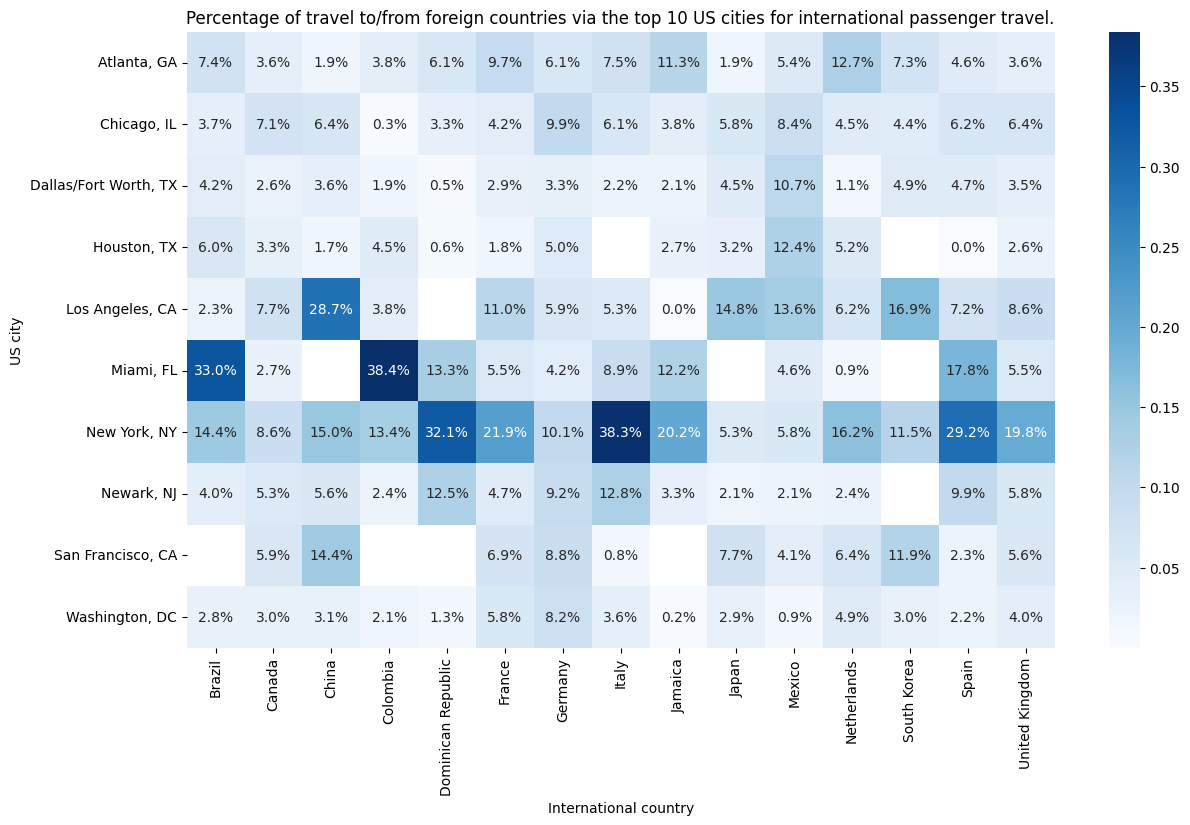

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(14, 8))

sns.heatmap(pct_of_passengers_country, cmap='Blues', annot=True, fmt='.1%', ax=axes)
axes.set(
    title='Percentage of travel to/from foreign countries via the top 10 US cities for international passenger travel.',
    xlabel='International country', ylabel='US city'
)